# REINFORCE

---

In this notebook, we will train REINFORCE with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [2]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from tqdm import tqdm as tqdm

### 2. Define the Architecture of the Policy

In [3]:
env = gym.make('CartPole-v0')
# env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)


### 3. Train the Agent with REINFORCE

In [4]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

print("")
def reinforce(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    bar = tqdm(range(1, n_episodes+1))
    for i_episode in bar:
        saved_log_probs = []
        rewards = []
        state = env.reset()[0]
        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, d1,d2, _ = env.step(action)
            rewards.append(reward)
            if d1 or d2:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])

        policy_loss = torch.sum(torch.cat([-log_prob*R for log_prob in saved_log_probs]))

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        bar.set_postfix(mean_score=np.mean(scores_deque))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break

    return scores

scores = reinforce()

  0%|          | 0/1000 [00:00<?, ?it/s]/home/inigo/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
 54%|█████▍    | 542/1000 [00:14<00:12, 36.66it/s, mean_score=195] 

Environment solved in 443 episodes!	Average Score: 195.43


### 4. Plot the Scores

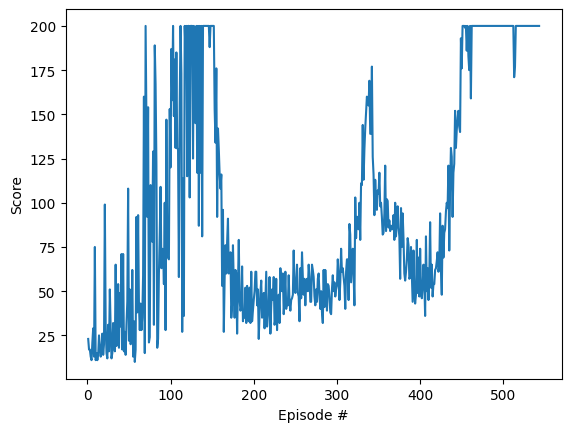

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

In [7]:
env = gym.make('CartPole-v0', render_mode='rgb_array')

import matplotlib.animation
from IPython.display import HTML



def render(env, agent):
    plt.style.use('ggplot')

    state = env.reset(seed=505)[0]
    score = 0
    frames = []
    while True:
        out = env.render()
        frames.append(out)
        action,_ = agent.act(state)
        state, reward, terminated, truncated, _ = env.step(action)
        score += reward
        if terminated or truncated:
            break

    fig = plt.figure()
    plt.axis('off')
    plt.grid(False)
    im = plt.imshow(out)

    def animation(i):
        im.set_data(frames[i])
        return im


    animation = matplotlib.animation.FuncAnimation(fig, animation, frames=len(frames), interval=50)
    plt.close()

    print('Final score:', score)
    env.close()
    return animation.to_html5_video()

HTML(render(env, policy))

/home/inigo/.local/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Final score: 200.0
